# Process Model Discovery and Visualization

by Giray Coksun (giray.coskun@tum.de)

In [30]:
from pathlib import Path

import pm4py
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

from pm4py.objects.conversion.heuristics_net import converter as hn_converter
from pm4py.objects.conversion.process_tree import converter as pt_converter

from pm4py.objects.conversion.bpmn import converter as bpmn_converter

from pm4py.write import write_bpmn

from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.bpmn import visualizer as bpmn_visualizer



In [4]:
XES_FILE_NAME = "BPI_Challenge_2017.xes"
XES_FILE_PATH = Path("data").joinpath(XES_FILE_NAME)

log = pm4py.read_xes(XES_FILE_PATH.__str__())

/Users/giraycoskun/Code/Courses/business-process-praktikum/.venv/lib/python3.13/site-packages/pm4py/utils.py:986: UserWarning: In the current version, the import/export operation uses `rustxes` by default for importing/exporting files faster. Please uninstall `rustxes` to revert the behavior.
  warnings.warn("In the current version, the import/export operation uses `rustxes` by default for importing/exporting files faster. Please uninstall `rustxes` to revert the behavior.")


In [6]:
models = {}

## Process Model Discovery: pm4py Inductive Miner


PROCESS DISCOVERY: Inductive Miner
  - Places: 55
  - Transitions: 87
  - Arcs: 184


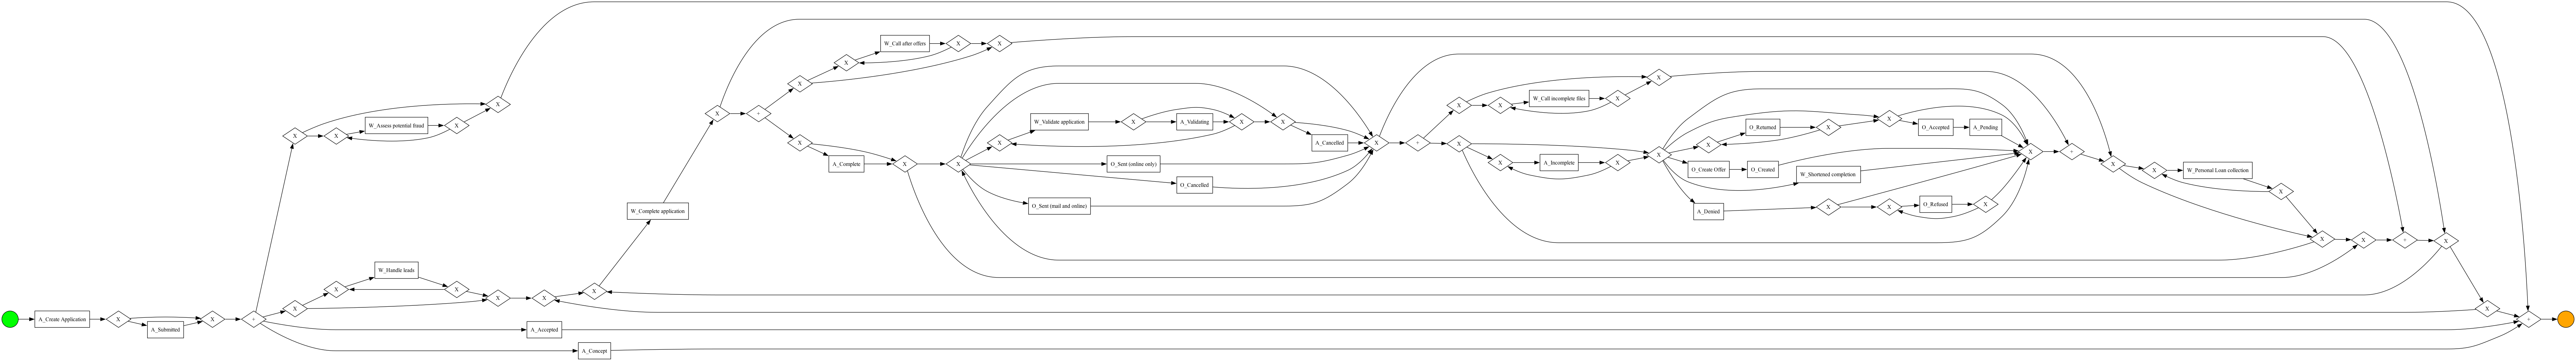

In [31]:
# Discover process tree
process_tree = inductive_miner.apply(log)

# Convert to Petri net
net, im, fm = pt_converter.apply(process_tree)

models['inductive'] = {
    'name': 'Inductive Miner',
    'net': net,
    'im': im,
    'fm': fm,
    'tree': process_tree
}
    
print("\n" + "=" * 80)
print("PROCESS DISCOVERY: Inductive Miner")
print("=" * 80)
print(f"  - Places: {len(net.places)}")
print(f"  - Transitions: {len(net.transitions)}")
print(f"  - Arcs: {len(net.arcs)}")

bpmn_graph = pm4py.convert_to_bpmn(net, im, fm)
pm4py.write_bpmn(bpmn_graph, 'inductive_discovery_model.bpmn', auto_layout=True)

bpmn_gviz = bpmn_visualizer.apply(bpmn_graph)
bpmn_visualizer.view(bpmn_gviz)

## Process Model Discovery: pm4py Alpha Miner


PROCESS DISCOVERY: Alpha Miner
  - Places: 12
  - Transitions: 26
  - Arcs: 55


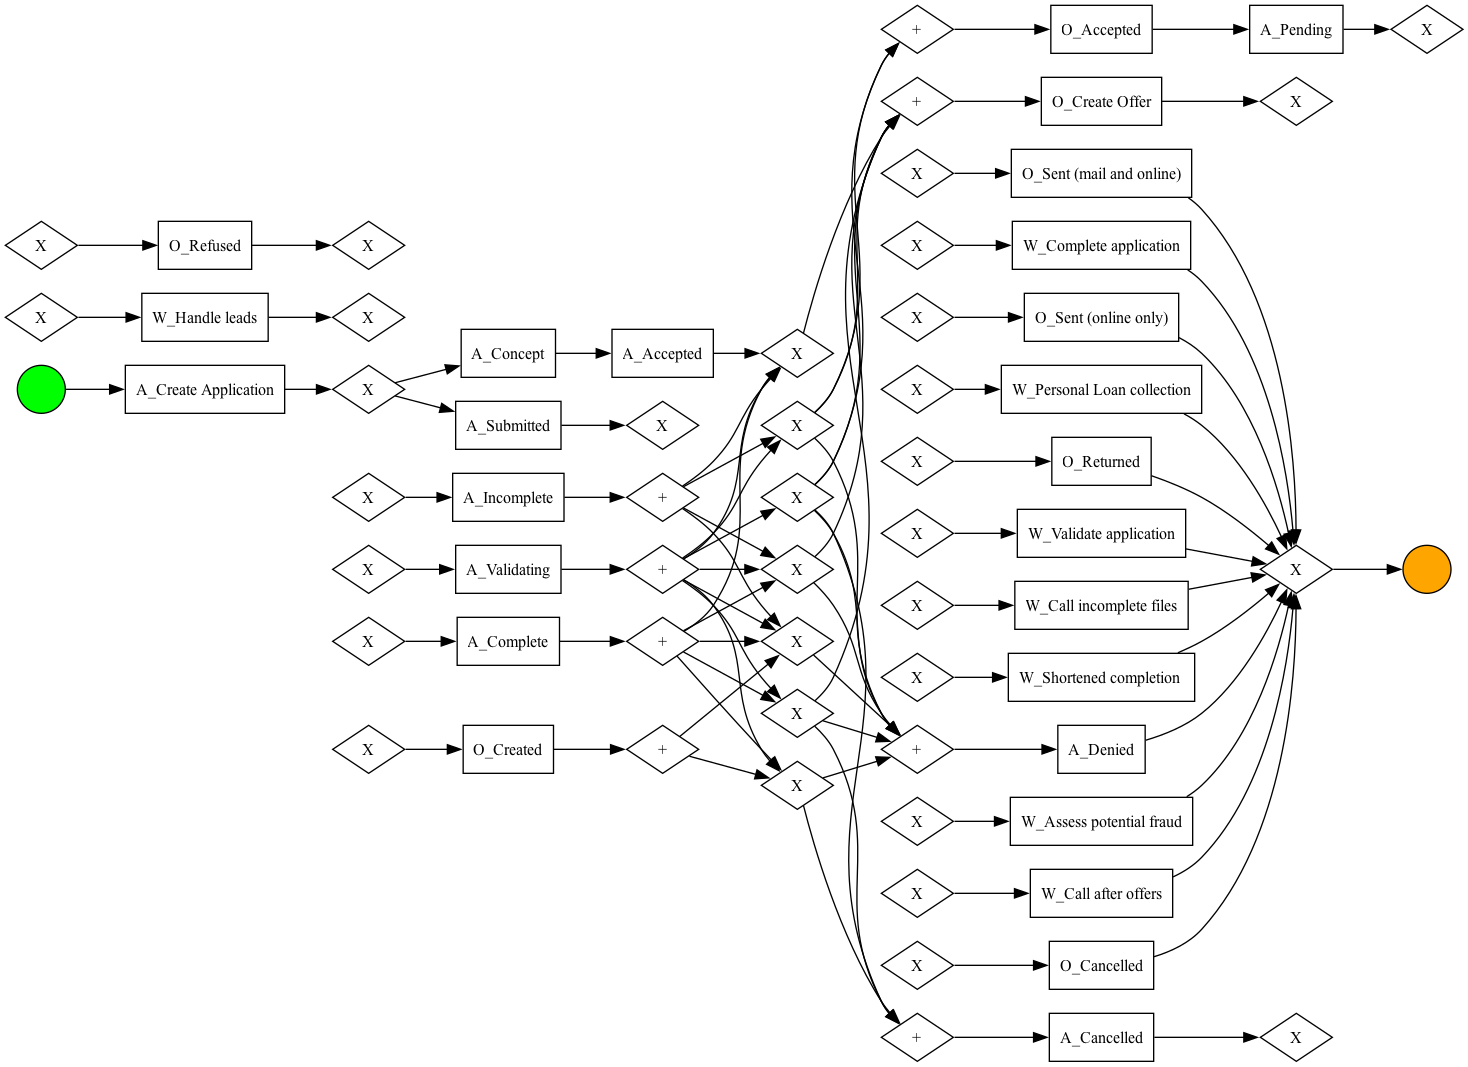

In [32]:
"""Process Discovery: Alpha Miner"""

# Discover Petri net
net, im, fm = alpha_miner.apply(log)

models['alpha'] = {
    'name': 'Alpha Miner',
    'net': net,
    'im': im,
    'fm': fm
}

print("\n" + "=" * 80)
print("PROCESS DISCOVERY: Alpha Miner")
print("=" * 80)
print(f"  - Places: {len(net.places)}")
print(f"  - Transitions: {len(net.transitions)}")
print(f"  - Arcs: {len(net.arcs)}")

bpmn_graph = pm4py.convert_to_bpmn(net, im, fm)
pm4py.write_bpmn(bpmn_graph, 'alpha_miner_discovery_model.bpmn', auto_layout=True)

bpmn_gviz = bpmn_visualizer.apply(bpmn_graph)
bpmn_visualizer.view(bpmn_gviz)
    

## Process Model Discovery: pm4py Heuristics Miner


PROCESS DISCOVERY: Heuristics Miner (threshold=0.9)
  - Places: 43
  - Transitions: 84
  - Arcs: 186


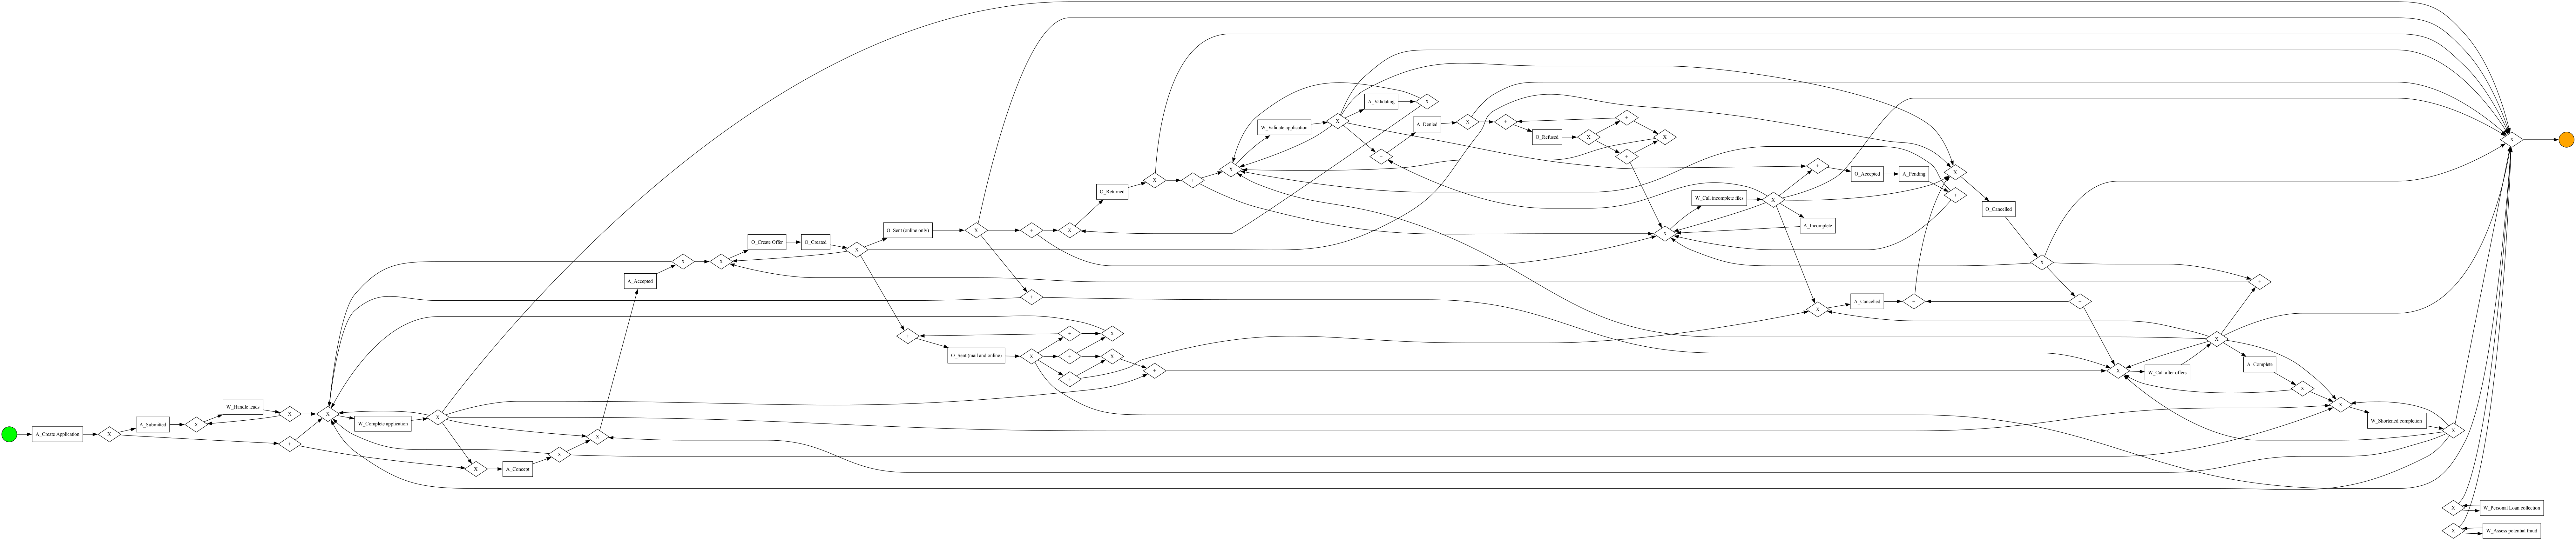

In [33]:
"""Process Discovery: Heuristics Miner"""

dependency_threshold = 0.9
# Discover heuristics net
net, im, fm = heuristics_miner.apply(log, 
                                    parameters={
                                        heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: dependency_threshold
                                    })

models['heuristics'] = {
    'name': f'Heuristics Miner (thresh={dependency_threshold})',
    'net': net,
    'im': im,
    'fm': fm,
    'heu_net': net
}
    
print("\n" + "=" * 80)
print(f"PROCESS DISCOVERY: Heuristics Miner (threshold={dependency_threshold})")
print("=" * 80)
print(f"  - Places: {len(net.places)}")
print(f"  - Transitions: {len(net.transitions)}")
print(f"  - Arcs: {len(net.arcs)}")

bpmn_graph = pm4py.convert_to_bpmn(net, im, fm)
pm4py.write_bpmn(bpmn_graph, 'heuristics_miner_discovery_model.bpmn', auto_layout=True)

bpmn_gviz = bpmn_visualizer.apply(bpmn_graph)
bpmn_visualizer.view(bpmn_gviz)

## Quality Metrics

In [45]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.objects.petri_net.utils import check_soundness

from src.metrics import custom_simplicity_metric_1, custom_simplicity_metric_2


In [44]:
model_metrics = {}

In [ ]:
model_key = ['inductive', 'alpha', 'heuristics']  # Change index to select model
for key in model_key:
    metrics = {}
    print(f"\n{'=' * 80}")
    print(f"QUALITY METRICS: {models[key]['name']}")
    print(f"{'=' * 80}")

    net = models[key]['net']
    im = models[key]['im']
    fm = models[key]['fm']

# 1. FITNESS (Token-based replay)
    fitness = replay_fitness.apply(log, net, im, fm,
                                            variant=replay_fitness.Variants.TOKEN_BASED)
    metrics['fitness'] = fitness['average_trace_fitness']
    print(f"Fitness: {metrics['fitness']:.4f}")

# 2. PRECISION (ETConformance)
    print("\n2. Computing Precision...")
    precision = precision_evaluator.apply(log, net, im, fm,
                                            variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
    metrics['precision'] = precision
    print(f"Precision: {metrics['precision']:.4f}")

# 3. GENERALIZATION
    print("\n3. Computing Generalization...")
    generalization = generalization_evaluator.apply(log, net, im, fm)
    metrics['generalization'] = generalization
    print(f"Generalization: {metrics['generalization']:.4f}")

# 4. SOUNDNESS CHECK
    print("\n7. Checking Soundness...")
    is_sound = check_soundness.check_easy_soundness_net_in_fin_marking(net, im, fm)
    metrics['is_sound'] = is_sound
    print(f"sSound: {is_sound}")
    
    metrics['soundness'] = is_sound
    
# 5. SIMPLICITY (pm4py)
    print("\n4. Computing Simplicity (pm4py)...")
    simplicity = simplicity_evaluator.apply(net)
    metrics['simplicity_pm4py'] = simplicity
    print(f"Simplicity: {metrics['simplicity_pm4py']:.4f}")

# 6. CUSTOM SIMPLICITY METRIC 1
    print("\n5. Computing Custom Simplicity Metric 1...")
    custom_simp1 = custom_simplicity_metric_1(net)
    metrics['custom_simplicity_1'] = custom_simp1
    print(f" {custom_simp1['metric_name']}: {custom_simp1['normalized_value']:.4f}")
    print(f"(Raw: {custom_simp1['raw_value']:.4f}, Places: {custom_simp1['places']}, "
            f"Trans: {custom_simp1['transitions']}, Arcs: {custom_simp1['arcs']})")
    
# 7. CUSTOM SIMPLICITY METRIC 2
    print("\n6. Computing Custom Simplicity Metric 2...")
    custom_simp2 = custom_simplicity_metric_2(net)
    metrics['custom_simplicity_2'] = custom_simp2
    print(f"{custom_simp2['metric_name']}: {custom_simp2['normalized_value']:.4f}")
    print(f"      (Raw degree: {custom_simp2['raw_value']:.4f}, "
            f"Total nodes: {custom_simp2['total_nodes']})")

    model_metrics[key] = metrics



QUALITY METRICS: Inductive Miner


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

Fitness: 1.0000

2. Computing Precision...


replaying log with TBR, completed traces ::   0%|          | 0/263907 [00:00<?, ?it/s]

Precision: 0.1407

3. Computing Generalization...


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

Generalization: 0.9485

7. Checking Soundness...
sSound: True

4. Computing Simplicity (pm4py)...
Simplicity: 0.6283

5. Computing Custom Simplicity Metric 1...
 Structural Complexity Ratio: 1.0000
      (Raw: 0.7717, Places: 55, Trans: 87, Arcs: 184)

6. Computing Custom Simplicity Metric 2...
   ✓ Average Node Degree: 0.8521
      (Raw degree: 2.5915, Total nodes: 142)

QUALITY METRICS: Alpha Miner


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

Fitness: 0.4039

2. Computing Precision...


replaying log with TBR, completed traces ::   0%|          | 0/263907 [00:00<?, ?it/s]

Precision: 0.0904

3. Computing Generalization...


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

Generalization: 0.9824

7. Checking Soundness...
sSound: True

4. Computing Simplicity (pm4py)...
Simplicity: 0.5278

5. Computing Custom Simplicity Metric 1...
 Structural Complexity Ratio: 0.9870
      (Raw: 0.6909, Places: 12, Trans: 26, Arcs: 55)

6. Computing Custom Simplicity Metric 2...
   ✓ Average Node Degree: 0.7763
      (Raw degree: 2.8947, Total nodes: 38)

QUALITY METRICS: Heuristics Miner (thresh=0.9)


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

Fitness: 0.9466

2. Computing Precision...


replaying log with TBR, completed traces ::   0%|          | 0/263907 [00:00<?, ?it/s]

Precision: 0.6317

3. Computing Generalization...


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

Generalization: 0.9341

7. Checking Soundness...
sSound: True

4. Computing Simplicity (pm4py)...
Simplicity: 0.5184

5. Computing Custom Simplicity Metric 1...
 Structural Complexity Ratio: 0.9754
      (Raw: 0.6828, Places: 43, Trans: 84, Arcs: 186)

6. Computing Custom Simplicity Metric 2...
   ✓ Average Node Degree: 0.7677
      (Raw degree: 2.9291, Total nodes: 127)


## Custom Process Model

In [ ]:
from pm4py.objects.bpmn.importer import importer as bpmn_importer


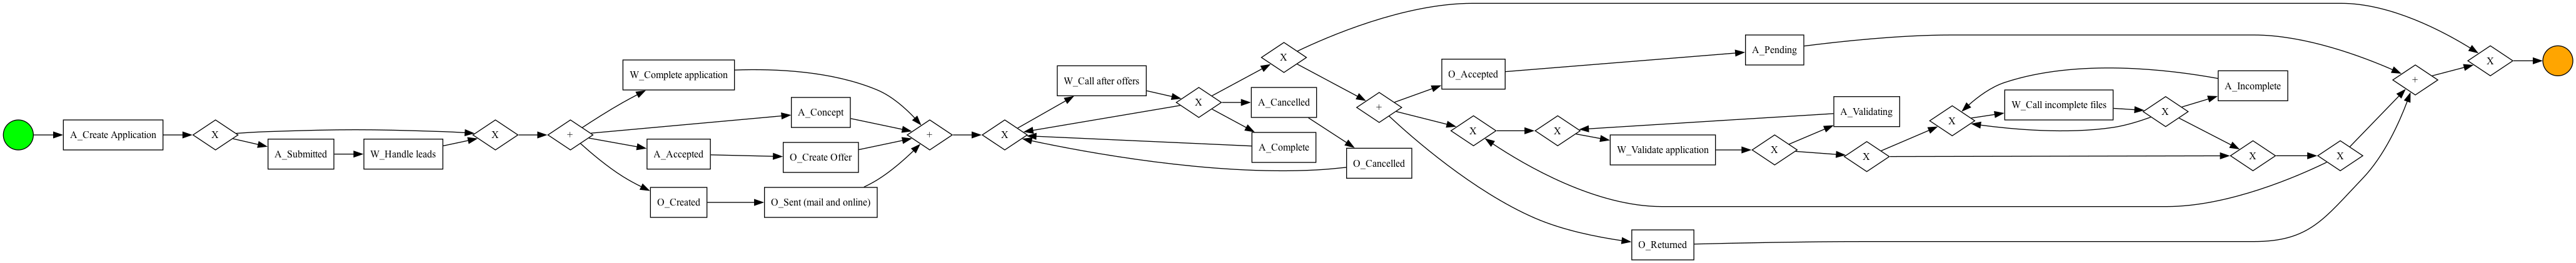

In [66]:
bpmn_path = "custom.bpmn"
bpmn_graph = bpmn_importer.apply(bpmn_path)

bpmn_gviz = bpmn_visualizer.apply(bpmn_graph)
bpmn_visualizer.view(bpmn_gviz)

In [67]:
net, im, fm = pm4py.convert_to_petri_net(bpmn_graph)

models['custom'] = {
    'name': 'Custom Model',
    'net': net,
    'im': im,
    'fm': fm,
}

In [68]:
key = 'custom'

metrics = {}
print(f"\n{'=' * 80}")
print(f"QUALITY METRICS: {models[key]['name']}")
print(f"{'=' * 80}")

net = models[key]['net']
im = models[key]['im']
fm = models[key]['fm']

# 1. FITNESS (Token-based replay)
fitness = replay_fitness.apply(log, net, im, fm,
                                        variant=replay_fitness.Variants.TOKEN_BASED)
metrics['fitness'] = fitness['average_trace_fitness']
print(f"Fitness: {metrics['fitness']:.4f}")

# 2. PRECISION (ETConformance)
print("\n2. Computing Precision...")
precision = precision_evaluator.apply(log, net, im, fm,
                                        variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
metrics['precision'] = precision
print(f"Precision: {metrics['precision']:.4f}")

# 3. GENERALIZATION
print("\n3. Computing Generalization...")
generalization = generalization_evaluator.apply(log, net, im, fm)
metrics['generalization'] = generalization
print(f"Generalization: {metrics['generalization']:.4f}")

# 4. SOUNDNESS CHECK
print("\n7. Checking Soundness...")
is_sound = check_soundness.check_easy_soundness_net_in_fin_marking(net, im, fm)
metrics['is_sound'] = is_sound
print(f"sSound: {is_sound}")

metrics['soundness'] = is_sound

# 5. SIMPLICITY (pm4py)
print("\n4. Computing Simplicity (pm4py)...")
simplicity = simplicity_evaluator.apply(net)
metrics['simplicity_pm4py'] = simplicity
print(f"Simplicity: {metrics['simplicity_pm4py']:.4f}")

# 6. CUSTOM SIMPLICITY METRIC 1
print("\n5. Computing Custom Simplicity Metric 1...")
custom_simp1 = custom_simplicity_metric_1(net)
metrics['custom_simplicity_1'] = custom_simp1
print(f" {custom_simp1['metric_name']}: {custom_simp1['normalized_value']:.4f}")
print(f"(Raw: {custom_simp1['raw_value']:.4f}, Places: {custom_simp1['places']}, "
        f"Trans: {custom_simp1['transitions']}, Arcs: {custom_simp1['arcs']})")

# 7. CUSTOM SIMPLICITY METRIC 2
print("\n6. Computing Custom Simplicity Metric 2...")
custom_simp2 = custom_simplicity_metric_2(net)
metrics['custom_simplicity_2'] = custom_simp2
print(f"{custom_simp2['metric_name']}: {custom_simp2['normalized_value']:.4f}")
print(f"      (Raw degree: {custom_simp2['raw_value']:.4f}, "
        f"Total nodes: {custom_simp2['total_nodes']})")

model_metrics[key] = metrics



QUALITY METRICS: Custom Model


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

Fitness: 0.9076

2. Computing Precision...


replaying log with TBR, completed traces ::   0%|          | 0/263907 [00:00<?, ?it/s]

Precision: 0.4524

3. Computing Generalization...


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

Generalization: 0.9947

7. Checking Soundness...
sSound: True

4. Computing Simplicity (pm4py)...
Simplicity: 0.7143

5. Computing Custom Simplicity Metric 1...
 Structural Complexity Ratio: 1.0000
(Raw: 0.8333, Places: 33, Trans: 37, Arcs: 84)

6. Computing Custom Simplicity Metric 2...
Average Node Degree: 0.9000
      (Raw degree: 2.4000, Total nodes: 70)
